In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, precision_score 
from sklearn.metrics import roc_auc_score,roc_curve, auc, RocCurveDisplay

# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
# откройте данные: ваш код здесь
data = pd.read_csv('./data/spam_or_not_spam.csv')

In [3]:
# рассчитайте частоты для классов : ваш код здесь
data.label.value_counts()

0    2500
1     500
Name: label, dtype: int64

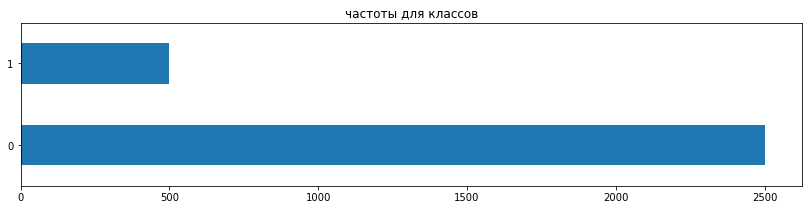

In [4]:
# визуализируйте результат: ваш код здесь
plt.figure(figsize=(14,3))
data.label.value_counts().plot.barh()
plt.title('частоты для классов')
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Замените все пустоты (пустые строки) в данных на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
#ваш код здесь
# data.email = data.email.where(~data.email.astype(str).str.isspace())
# data.dropna(axis=0,inplace=True)
data = data.replace('', np.nan).dropna(axis=0)

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
#ваш код здесь
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
#ваш код здесь
# X уже определен 
y = data.label

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [10]:
#ваш код здесь

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [12]:
#ваш код здесь
y_test.mean()

0.164

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [13]:
#ваш код здесь

In [14]:
clf = ComplementNB(alpha = 0.01)
clf.fit(X_train,y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [15]:
#ваш код здесь
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred):.3f}')
print(f'Precision: {precision_score(y_test,y_pred):.3f}')
print(f'ROC_AUC: {roc_auc_score(y_test,y_pred_proba[:,1]):.3f}')

Accuracy: 0.995
Precision: 0.984
ROC_AUC: 0.987


Нарисуйте ROC-кривую:

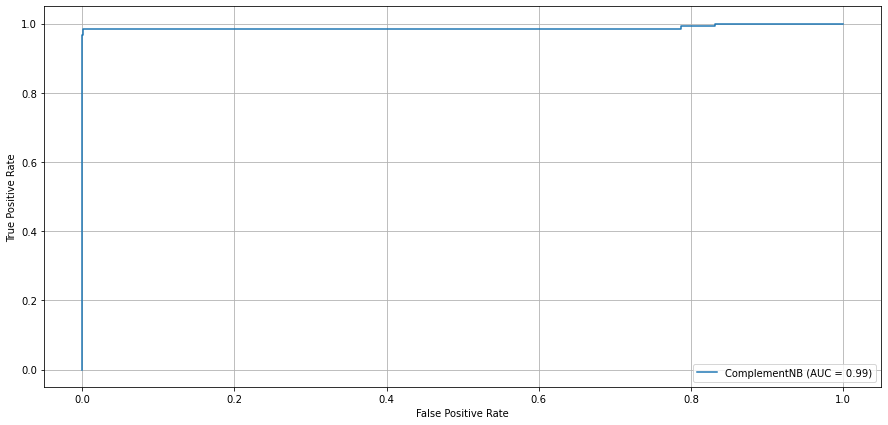

In [16]:
#ваш код здесь
fpr, tpr, _ = roc_curve(y_test,y_pred_proba[:,1])
roc_auc = auc(fpr, tpr) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='ComplementNB')
fig, ax = plt.subplots(figsize=(15, 7))
display.plot(ax=ax)
plt.grid(True)
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

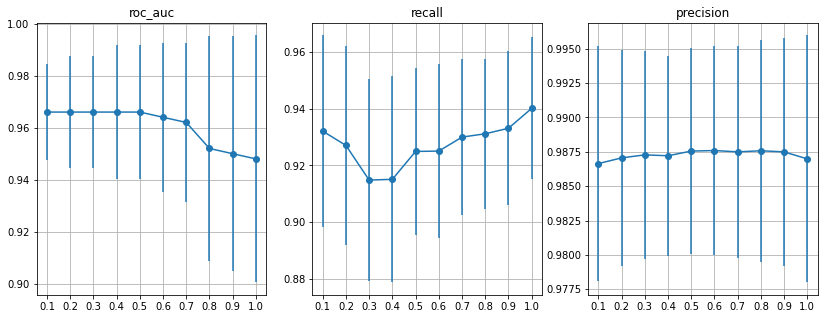

In [17]:
#ваш код здесь
scoring = ['recall','precision','roc_auc']
alpha_scale = np.linspace(0.1,1,num=10)
test_recall,test_precision,test_roc_auc = np.array([]),np.array([]),np.array([])

for alpha in alpha_scale:
    clf = ComplementNB(alpha=alpha)
    cv_metrics = cross_validate(clf, X, y, cv=5, scoring=scoring)
    test_recall = np.append(test_recall,cv_metrics['test_recall'])
    test_precision = np.append(test_precision,cv_metrics['test_precision'])
    test_roc_auc = np.append(test_roc_auc,cv_metrics['test_roc_auc'])

test_recall = test_recall.reshape(-1,5)
test_precision = test_precision.reshape(-1,5)
test_roc_auc = test_roc_auc.reshape(-1,5)

fig, axes = plt.subplots(1,3,figsize = (14,5))
for i,dt in enumerate([test_recall,test_precision,test_roc_auc]):
    plt.subplot(axes[i])
    plt.title(scoring[i-1])
    plt.grid(True)
    plt.xticks(alpha_scale)
    plt.errorbar(alpha_scale, dt.mean(axis=1) , yerr = dt.std(axis=1), fmt='o-')

Как видим явной зависимости качества от параметра сглаживания $\alpha$ не наблюдается. Если рассмотреть более детально -  при приближении к 1 немного растет **полнота** и немного падает **ROC AUC**, что как я понимаю, обьясняется большими апостериорными вероятностями слов не встречающихся в обучающей выборке. Это повышает вероятность отнесения письма к спаму -  **recall** растет (большая доля спама определяется как спам), но посколькку в неизученных словах неспамных должно быть больше, то рост апостериорных вероятностей всех неузученных слов приводит к тому что **FP** растет быстрее **TP**, поэтому ROC кривая немного прижимается к диагонали, ROC AUC немного падает.